# 0.0. BUSINESS PROBLEM

## 0.1. Challenge

Find who are most valuable customers to be part of "Insiders" group program. 

## 0.2. Business Questions

1. Who are the customers elegible to participate of Insiders group?
2. How many customers will be part of the group?
3. What are main characteristics of these customers?
4. What is the revenue participation percentaga from Insiders group?
5. What is the expected revenue for the next few months from Insiders group?
6. What conditions a customer must meet to be an Insider?
7. What condisions a customer must meet to be excluded from Insiders group?
8. How to ensure that Insiders group is better than the rest of the customer base?
9. What can Marketing do to increase revenue?

# 1.0. FUNCTIONS & LIBS

## 1.1. Imports

In [77]:
import re
import datetime
import pickle
import optuna

import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly        import express       as px
from sklearn       import cluster       as C
from sklearn       import metrics       as M
from sklearn       import mixture       as mx
from sklearn       import manifold      as mn
from sklearn       import ensemble      as en
from sklearn       import decomposition as dc
from sklearn       import preprocessing as pp
from matplotlib    import pyplot        as plt
from matplotlib    import colormaps     as cm
from scipy.cluster import hierarchy     as hc

## 1.2. Helper Functions

In [78]:
pd.options.mode.chained_assignment = None

# Defining an objective function to be optimized
def bayesian_opt_objective(trial):
    eps = trial.suggest_float('eps', 0.30, 0.40, step=0.005)
    min_samples = trial.suggest_int('min_samples', 5, 50, step=5)

    # Defining the model
    dbscan_model = C.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

    # Training the model and predicting
    labels = dbscan_model.fit_predict(X)

    # Performance
    sil = M.silhouette_score(X, labels, metric='euclidean')

    return sil 

# 2.0. DATA DESCRIPTION

## 2.1. Variables

**Invoice Number** - unique identifier of each transaction

**Stock Code Product** - item code

**Description Product** - item name

**Quantity** - quantity of each item from a transaction

**Invoice Date** - transaction day

**Unit Price** - item price

**Customer ID** - unque customer identifier

**Country** - country where customer lives

## 2.2. Load Data

In [79]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='iso-8859-1')
df_raw = df_raw.drop(columns = 'Unnamed: 8')

## 2.3. Rename Columns

In [80]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df_raw.columns = cols_new

## 2.4. DF Dimensions

In [81]:
print('Number of rows: {}'.format(df_raw.shape[0]))
print('Number of columns: {}'.format(df_raw.shape[1]))

Number of rows: 541909
Number of columns: 8


## 2.5. Check NA and Duplicates

In [82]:
# check NA
print('Number of NAs:')
print(df_raw.isna().sum())

# check duplicates
print('\nNumber of Duplicated:')
print(df_raw.duplicated().sum())

Number of NAs:
invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

Number of Duplicated:
5269


In [83]:
# df_raw[df_raw.duplicated(keep=False)].sort_values(by=['customer_id','invoice_no', 'stock_code']).tail(15)
# # after investigating duplicated rows, it was decided to consider them as authentic transactions

### 2.5.1. Replace NA

In [84]:
# separate rows with missing costumers
df_raw_missing = df_raw.loc[df_raw['customer_id'].isna(), :]

In [85]:
# create reference
df_backup = pd.DataFrame(df_raw_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, (19000+len(df_backup)), 1)

# merge original with reference data
df_raw = pd.merge(df_raw, df_backup, on='invoice_no', how='left')

# coalesce
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first(df_raw['customer_id_y'])

# drop extra columns
df_raw = df_raw.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

## 2.6. Check DTypes

In [86]:
df_raw.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

### 2.6.1 Change DTypes

In [87]:
df_raw = df_raw.astype({'customer_id': 'int64'})
df_raw['invoice_date'] = pd.to_datetime(df_raw['invoice_date'], format='%d-%b-%y')

In [88]:
df_raw.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.7. Descriptive Analysis

In [89]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_raw.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [90]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate results
df_num_att = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T. reset_index()
df_num_att.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [91]:
df_num_att

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


In [92]:
# need further investigations: unit_price = 0, and quantity < 0

### 2.7.2. Pandas Profiling

In [93]:
# pd_profile = ProfileReport(df_raw)
# pd_profile.to_file('output_df_raw_02R.html')

# 3.0. DATA FILTERING

In [94]:
df_raw_3 = df_raw.copy()

## 3.1. Data Filtering Analysis

### 3.1.1. unit_price
filter prices lower than 0.01

In [95]:
# investigating prices = 0
df_raw_3[df_raw_3['unit_price']<=0.01].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
292266,562544,84920,NaN,-9,2017-08-03,0.0,United Kingdom,21462
171577,551433,21784,NaN,-2,2017-04-26,0.0,United Kingdom,20447
7187,536995,35951,NaN,57,2016-12-01,0.0,United Kingdom,19035
390852,570599,84596G,??,-365,2017-10-09,0.0,United Kingdom,21991
12008,537361,21777,NaN,5,2016-12-04,0.0,United Kingdom,19074


In [96]:
# investiating prices = 0.001
df_raw_3[df_raw_3['unit_price']==0.04]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.04,United Kingdom,15799
221726,556267,16045,POPART WOODEN PENCILS ASST,500,2017-06-07,0.04,United Kingdom,13694
228959,557006,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,United Kingdom,14282
229052,557009,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,United Kingdom,14321
229499,557057,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,United Kingdom,16843
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.04,United Kingdom,16900
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,United Kingdom,15721
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,United Kingdom,17379
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.04,United Kingdom,14456


In [97]:
# investigating prices too high
df_raw_3[df_raw_3['unit_price']>500].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
370505,569137,DOT,DOTCOM POSTAGE,1,2017-09-28,639.83,United Kingdom,21863
119631,C546557,M,Manual,-1,2017-03-13,2583.76,Hong Kong,19862
16357,C537652,AMAZONFEE,AMAZON FEE,-1,2016-12-05,6706.71,United Kingdom,19119
14392,537534,M,Manual,1,2016-12-05,924.59,United Kingdom,19098
515281,579777,DOT,DOTCOM POSTAGE,1,2017-11-28,888.42,United Kingdom,22611
235379,C557638,POST,POSTAGE,-1,2017-06-19,545.58,United Kingdom,17450
271151,C560647,M,Manual,-1,2017-07-18,3060.60,United Kingdom,18102
481174,C577348,M,Manual,-1,2017-11-16,1149.98,United Kingdom,22475
484492,577531,DOT,DOTCOM POSTAGE,1,2017-11-18,1236.75,United Kingdom,22479
28992,C538680,BANK CHARGES,Bank Charges,-1,2016-12-11,966.92,United Kingdom,19207


### 3.1.2. quantity
- All invoices with string in the description have negative quantity. It will be considered as returns
- There some high suspect high quantities, however doesn't seem to be errors

In [98]:
# check samples
df_raw_3[df_raw_3['quantity']<-9000]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.03,United Kingdom,15838
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,United Kingdom,12346
225528,556687,23003,Printing smudges/thrown away,-9058,2017-06-12,0.00,United Kingdom,20913
225529,556690,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20914
225530,556691,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20915
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [99]:
# investigating extreme values
df_raw_3[(df_raw_3['quantity']<-9000)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.03,United Kingdom,15838
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,United Kingdom,12346
225528,556687,23003,Printing smudges/thrown away,-9058,2017-06-12,0.00,United Kingdom,20913
225529,556690,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20914
225530,556691,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20915
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [100]:
# investiganting if invoice_no has any relation with negative values
df_invoice_str = df_raw_3.loc[df_raw_3['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]

# df_invoice_str[df_invoice_str['quantity']>=0]
# df_aux = df_raw_3[df_raw_3['quantity']>0]
# df_aux = df_aux.astype({'invoice_no':'int64'})

In [101]:
# df_raw_3[(df_raw_3['customer_id']==13256)].sort_values('quantity')

### 3.1.3. stock_code
Exclude stock_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES'] (do not seem to be relevant to the model

In [102]:
df_raw_3.loc[df_raw_3['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
# POST - seems to be cost of exportation to another coutry
# D - discount
# M - seems to be some kind of manual adjustment
# PADS - seems to be some kind of protection that goes in the package
# DOTCOM - ??
# CRUK - ??

# list created using libreoffice calc
exclude_stock_codes = [
'AMAZONFEE',
'B',
'BANK CHARGES',
'C2',
'CRUK',
'D',
'DCGS0003',
'DCGS0004',
'DCGS0055',
'DCGS0057',
'DCGS0066P',
'DCGS0067',
'DCGS0068',
'DCGS0069',
'DCGS0070',
'DCGS0071',
'DCGS0072',
'DCGS0073',
'DCGS0074',
'DCGS0076',
'DCGSSBOY',
'DCGSSGIRL',
'DOT',
'gift_0001_10',
'gift_0001_20',
'gift_0001_30',
'gift_0001_40',
'gift_0001_50',
'M',
'm',
'PADS',
'POST',
'S']

### 3.1.4. country
Do not remove yet

In [103]:
df_raw_3['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [104]:
df_raw_3['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [105]:
df_raw_3[df_raw_3['country']=='European Community']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
168149,551013,22839,3 TIER CAKE TIN GREEN AND CREAM,1,2017-04-24,14.95,European Community,15108
168150,551013,22840,ROUND CAKE TIN VINTAGE RED,2,2017-04-24,7.95,European Community,15108
168151,551013,22841,ROUND CAKE TIN VINTAGE GREEN,2,2017-04-24,7.95,European Community,15108
168152,551013,22457,NATURAL SLATE HEART CHALKBOARD,6,2017-04-24,2.95,European Community,15108
168153,551013,22314,OFFICE MUG WARMER CHOC+BLUE,6,2017-04-24,2.95,European Community,15108
...,...,...,...,...,...,...,...,...
273232,560783,21098,CHRISTMAS TOILET ROLL,12,2017-07-19,1.25,European Community,15108
273233,560783,72807C,SET/3 VANILLA SCENTED CANDLE IN BOX,12,2017-07-19,4.25,European Community,15108
273234,560783,85036B,CHOCOLATE 1 WICK MORRIS BOX CANDLE,12,2017-07-19,4.25,European Community,15108
273235,560783,85035C,ROSE 3 WICK MORRIS BOX CANDLE,8,2017-07-19,4.25,European Community,15108


## 3.2. Data Filtering

In [106]:
# unit price
df_raw_3 = df_raw_3.loc[df_raw_3['unit_price']>0.01,:]

# stock code
df_raw_3 = df_raw_3[~df_raw_3['stock_code'].isin(exclude_stock_codes)]

# quantity
df_raw_returns = df_raw_3.loc[df_raw_3['quantity']<0, :]
df_raw_purchases = df_raw_3.loc[df_raw_3['quantity']>=0, :]

# 4.0. FEATURE ENGINEERING

In [107]:
df_raw_4 = df_raw_3.copy()

## 4.1. Features Creation

In [108]:
# separate unique customers
df_ref = df_raw_4.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 4.1.1. Gross Revenue - total money spent by customer

In [109]:
# calculated from total invoices (returns are subtracted from gross revenue)
df_raw_4['gross_revenue'] = df_raw_4['quantity']*df_raw_4['unit_price']
df_gross_revenue = df_raw_4[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_gross_revenue, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

### 4.1.2. Average Ticket Value - average amount of money spent by customer on each transaction

In [110]:
df_avg_ticket = (df_raw_4[['customer_id', 'invoice_no', 'gross_revenue']].groupby('customer_id')
                                                                         .agg(n_invoices=('invoice_no', 'nunique'),
                                                                              sum_revenue=('gross_revenue', 'sum'))
                                                                         .reset_index())
df_avg_ticket['avg_ticket'] = df_avg_ticket['sum_revenue']/df_avg_ticket['n_invoices']
df_ref = pd.merge(df_ref, df_avg_ticket[['customer_id', 'avg_ticket']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
avg_ticket       0
dtype: int64

### 4.1.3. Recency - number of days since last purchase

In [111]:
# recency - last day of purchase
# calculated from dataframe with only purchases
df_recency = df_raw_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency'] = (df_raw_4['invoice_date'].max()-df_recency['invoice_date']).dt.days+1
df_recency = df_recency[['customer_id', 'recency']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
avg_ticket        0
recency          67
dtype: int64

### 4.1.4. Frequency - number of purchases in last 365 days

In [112]:
# frequency - number of purchases in last 365 days
dd = datetime.timedelta(days=365)
df_frequency = df_raw_purchases[df_raw_purchases['invoice_date']>=(df_raw_purchases['invoice_date'].max() - dd)][['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'frequency'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue      0
avg_ticket         0
recency           67
frequency        177
dtype: int64

### 4.1.5. Quantity of Returns - number of invoices with negative quantity

In [113]:
df_returns = (df_raw_returns[['customer_id', 'invoice_no']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .count()
                                                           .reset_index()
                                                           .rename(columns={'invoice_no':'qty_returns'}))
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue       0
avg_ticket          0
recency            67
frequency         177
qty_returns      4199
dtype: int64

### 4.1.6. Amount Returned

In [114]:
df_raw_returns['amount_returned'] = df_raw_returns['quantity']*df_raw_returns['unit_price']*-1
df_amount_returned = df_raw_returns[['customer_id', 'amount_returned']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_amount_returned, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              67
frequency           177
qty_returns        4199
amount_returned    4199
dtype: int64

### 4.1.7. Quantity of Products

In [115]:
df_quantity = (df_raw_4[['customer_id','quantity']].groupby('customer_id')
                                                           .sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'qty_items'}))
df_ref = pd.merge(df_ref, df_quantity, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              67
frequency           177
qty_returns        4199
amount_returned    4199
qty_items             0
dtype: int64

### 4.1.8. Average Basket Size - quantity of products / total of invoices

In [116]:
df_avg_bs = (df_raw_4[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchases=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())
df_avg_bs['avg_basket_size'] = df_avg_bs['n_products']/df_avg_bs['n_purchases']
df_ref = pd.merge(df_ref, df_avg_bs[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              67
frequency           177
qty_returns        4199
amount_returned    4199
qty_items             0
avg_basket_size       0
dtype: int64

### 4.1.9. Assortment- quantity of distinct items purchased

In [117]:
df_assortment = (df_raw_purchases[['customer_id', 'stock_code']].drop_duplicates()
                                                                .groupby('customer_id')
                                                                .count()
                                                                .reset_index()
                                                                .rename(columns={'stock_code': 'assortment'}))
df_ref = pd.merge(df_ref, df_assortment, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              67
frequency           177
qty_returns        4199
amount_returned    4199
qty_items             0
avg_basket_size       0
assortment           67
dtype: int64

## 4.2. Check NA and DTypes after Feature Creation

In [118]:
# NANs
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              67
frequency           177
qty_returns        4199
amount_returned    4199
qty_items             0
avg_basket_size       0
assortment           67
dtype: int64

In [119]:
# DTypes
df_ref.dtypes

customer_id          int64
gross_revenue      float64
avg_ticket         float64
recency            float64
frequency          float64
qty_returns        float64
amount_returned    float64
qty_items            int64
avg_basket_size    float64
assortment         float64
dtype: object

### 4.2.1. Replace NA in df_ref

In [120]:
# nan values were assigned to customers with 0 purchases in the last 365 days
df_ref['frequency'] = df_ref['frequency'].fillna(0)

# nan values were assigned to customers wih 0 returns
df_ref['qty_returns'] = df_ref['qty_returns'].fillna(0)
df_ref['amount_returned'] = df_ref['amount_returned'].fillna(0)

# drop NA for remaining attributes
df_ref = df_ref.dropna()

In [121]:
# change dtypes
df_ref = df_ref.astype({'recency':'int64', 
                        'frequency': 'int64', 
                        'qty_returns':'int64',
                        'qty_items': 'int64',
                        'assortment':'int64'})

# 5.0. EDA (EXPLORATORY DATA ANALYSIS)

In [122]:
df_ref_5 = df_ref.copy()

## 5.1. Univariate Analysis

In [123]:
# pd_profile = ProfileReport(df_ref_5)
# pd_profile.to_file('output_df_ref_5_03R.html')

### 5.1.1. Gross Revenue
- OK

In [124]:
df_ref_5[df_ref_5['gross_revenue']>180000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
433,17450,189735.53,3872.153673,9,44,3,4815.26,69041,1409.000000,124
490,18102,259657.30,4327.621667,1,57,0,0.00,64124,1068.733333,150
1014,14646,278778.02,3818.876986,2,72,1,360.00,196556,2692.547945,699


In [125]:
df_raw_4[df_raw_4['customer_id']==18102].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
439056,574352,23534,WALL ART STOP FOR TEA,126,2017-11-02,3.88,United Kingdom,18102,488.88
282709,561655,22189,CREAM HEART CARD HOLDER,324,2017-07-26,2.31,United Kingdom,18102,748.44
16441,537659,22833,HALL CABINET WITH 3 DRAWERS,72,2016-12-05,32.69,United Kingdom,18102,2353.68
373668,569343,21174,POTTERING IN THE SHED METAL SIGN,120,2017-10-01,1.85,United Kingdom,18102,222.00
353504,567806,23092,LARGE ANTIQUE WHITE PHOTO FRAME,12,2017-09-20,5.49,United Kingdom,18102,65.88
373192,569263,23521,CAT AND BIRD WALL ART,240,2017-10-01,1.12,United Kingdom,18102,268.80
247848,558776,48173C,DOORMAT BLACK FLOCK,200,2017-07-02,4.58,United Kingdom,18102,916.00
343137,566934,48173C,DOORMAT BLACK FLOCK,93,2017-09-13,4.58,United Kingdom,18102,425.94
16433,537659,22765,NEWSPAPER STAND,23,2016-12-05,9.89,United Kingdom,18102,227.47
84318,543378,22189,CREAM HEART CARD HOLDER,504,2017-02-05,2.31,United Kingdom,18102,1164.24


### 5.1.2. Average Ticket
- OK

In [126]:
df_ref_5[df_ref_5['avg_ticket']>5000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
97,19014,6308.16,6308.160000,374,0,0,0.00,1477,1477.000000,589
235,19027,6369.56,6369.560000,372,0,0,0.00,1640,1640.000000,585
257,19033,10661.69,10661.690000,372,0,0,0.00,1834,1834.000000,145
353,19069,6471.71,6471.710000,369,0,0,0.00,1607,1607.000000,594
355,19070,6719.61,6719.610000,369,0,0,0.00,1810,1810.000000,567
426,19084,7272.41,7272.410000,369,0,0,0.00,1868,1868.000000,673
478,19109,5457.72,5457.720000,368,0,0,0.00,1447,1447.000000,600
479,19111,11540.34,11540.340000,368,0,0,0.00,2200,2200.000000,148
556,19125,5344.29,5344.290000,367,0,0,0.00,1483,1483.000000,588
632,19154,6366.58,6366.580000,366,1,0,0.00,1640,1640.000000,646


In [127]:
df_raw_4[df_raw_4['customer_id']==15098]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2017-06-08,4.95,United Kingdom,15098,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2017-06-08,649.50,United Kingdom,15098,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2017-06-08,649.50,United Kingdom,15098,649.5
222692,C556448,22502,PICNIC BASKET WICKER SMALL,-60,2017-06-08,4.95,United Kingdom,15098,-297.0


### 5.1.3. Frequency
- OK

In [128]:
df_ref_5[df_ref_5['frequency']>180]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
47,12748,30486.53,140.490922,1,192,11,1830.79,23976,110.488479,1766
66,14911,128882.13,532.570785,2,191,44,7393.59,76848,317.553719,1785


In [129]:
df_raw_4[df_raw_4['customer_id']==14911].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
205261,554770,22550,HOLIDAY FUN LUDO,4,2017-05-24,3.75,EIRE,14911,15.00
364225,568654,22699,ROSES REGENCY TEACUP AND SAUCER,6,2017-09-26,2.95,EIRE,14911,17.70
340362,566625,23400,SHELF WITH 4 HOOKS HOME SWEET HOME,2,2017-09-12,6.25,EIRE,14911,12.50
240711,558113,23202,JUMBO BAG VINTAGE LEAF,10,2017-06-25,2.08,EIRE,14911,20.80
475543,576899,23174,REGENCY SUGAR BOWL GREEN,4,2017-11-15,4.15,EIRE,14911,16.60
348169,567378,23310,BUBBLEGUM RING ASSORTED,72,2017-09-18,0.42,EIRE,14911,30.24
364267,568654,22927,GREEN GIANT GARDEN THERMOMETER,2,2017-09-26,5.95,EIRE,14911,11.90
148265,549196,22037,ROBOT BIRTHDAY CARD,12,2017-04-05,0.42,EIRE,14911,5.04
410723,572127,84596F,SMALL MARSHMALLOWS PINK BOWL,16,2017-10-19,0.42,EIRE,14911,6.72
283722,561798,22729,ALARM CLOCK BAKELIKE ORANGE,4,2017-07-27,3.75,EIRE,14911,15.00


### 5.1.4. Quantity of Returns
- OK

In [130]:
df_ref_5[df_ref_5['qty_returns']>30]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
66,14911,128882.13,532.570785,2,191,44,7393.59,76848,317.553719,1785
68,17841,40333.22,238.658107,2,121,45,634.50,22850,135.207101,1322
96,14606,11567.10,92.536800,2,87,35,439.55,5969,47.752000,816


In [131]:
df_raw_4[df_raw_4['customer_id']==17841].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
235323,557636,21122,SET/10 PINK POLKADOT PARTY CANDLES,2,2017-06-19,1.25,United Kingdom,17841,2.50
428690,573496,21935,SUKI SHOULDER BAG,1,2017-10-29,1.65,United Kingdom,17841,1.65
206560,554942,79321,CHILLI LIGHTS,1,2017-05-25,5.75,United Kingdom,17841,5.75
335965,566296,22893,MINI CAKE STAND T-LIGHT HOLDER,5,2017-09-09,0.42,United Kingdom,17841,2.10
200848,554160,21975,PACK OF 60 DINOSAUR CAKE CASES,8,2017-05-21,0.55,United Kingdom,17841,4.40
280679,561485,21090,SET/6 COLLAGE PAPER PLATES,6,2017-07-25,0.39,United Kingdom,17841,2.34
451922,575298,21930,JUMBO STORAGE BAG SKULLS,1,2017-11-07,2.08,United Kingdom,17841,2.08
393303,570818,23228,FILIGREE HEART BIRD WHITE,1,2017-10-10,1.25,United Kingdom,17841,1.25
280693,561485,22677,FRENCH BLUE METAL DOOR SIGN 2,1,2017-07-25,1.25,United Kingdom,17841,1.25
499610,578678,23583,LUNCH BAG PAISLEY PARK,1,2017-11-22,1.65,United Kingdom,17841,1.65


### 5.1.5. Amount Returned
- OK

In [132]:
df_ref_5[df_ref_5['amount_returned']>50000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
1379,12346,0.0,0.000000,326,1,1,77183.6,0,0.000000,1
3328,16446,2.9,0.966667,1,2,1,168469.6,2,0.666667,3


In [133]:
df_raw_4[df_raw_4['customer_id']==16446]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446,168469.60
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446,-168469.60


### 5.1.6. Quantity of Items
- Change method of calculation to sum negative values of returns, so we have qty of items that was sold and not returned - **DONE**
- **OBS**: filter values <= 0

In [134]:
# df_ref_5[df_ref_5['qty_items']>50000].sort_values('qty_items', ascending=False)
df_ref_5[df_ref_5['qty_items']<=0]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
16,17548,-1.414800e+02,-4.716000e+01,234,1,2,244.78,-132,-44.0,5
132,16546,-9.593000e+01,-3.197667e+01,291,1,1,883.08,-303,-101.0,25
1233,13672,0.000000e+00,0.000000e+00,302,2,3,186.39,0,0.0,4
1379,12346,0.000000e+00,0.000000e+00,326,1,1,77183.60,0,0.0,1
3114,13762,3.552714e-15,1.776357e-15,219,1,1,306.72,0,0.0,7
4145,18268,0.000000e+00,0.000000e+00,135,1,1,25.50,0,0.0,1
4579,14557,0.000000e+00,0.000000e+00,86,1,1,788.38,0,0.0,16
4594,16878,0.000000e+00,0.000000e+00,85,1,1,13.30,0,0.0,3
4780,13364,0.000000e+00,0.000000e+00,72,1,1,134.96,0,0.0,10
4886,14792,0.000000e+00,0.000000e+00,64,1,1,6.20,0,0.0,2


In [135]:
df_raw_4[df_raw_4['customer_id']==12558]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
519634,580158,22712,CARD DOLLY GIRL,12,2017-11-30,0.42,USA,12558,5.04
519635,580158,23344,JUMBO BAG 50'S CHRISTMAS,10,2017-11-30,2.08,USA,12558,20.80
519636,580158,85099B,JUMBO BAG RED RETROSPOT,10,2017-11-30,2.08,USA,12558,20.80
519637,580158,23209,LUNCH BAG VINTAGE DOILY,20,2017-11-30,1.65,USA,12558,33.00
519638,580158,79191C,RETRO PLASTIC ELEPHANT TRAY,24,2017-11-30,0.85,USA,12558,20.40
519639,580158,23392,SPACEBOY ROCKET LOLLY MAKERS,24,2017-11-30,2.08,USA,12558,49.92
519640,580158,84828,JUNGLE POPSICLES ICE LOLLY MOULDS,24,2017-11-30,1.25,USA,12558,30.00
519641,580158,23158,SET OF 5 LUCKY CAT MAGNETS,36,2017-11-30,2.08,USA,12558,74.88
519642,580158,21507,ELEPHANT BIRTHDAY CARD,12,2017-11-30,0.42,USA,12558,5.04
519643,580158,21508,VINTAGE KID DOLLY CARD,12,2017-11-30,0.42,USA,12558,5.04


### 5.1.7. Average Basket Size
- Change method of calculation to sum negative values of returns, so we have qty of items that was sold and not returned - **DONE**
- **OBS**: filter values <= 0

In [136]:
# df_ref_5[df_ref_5['avg_basket_size']>5000].sort_values('avg_basket_size', ascending=False)
df_ref_5[df_ref_5['avg_basket_size']<=0]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
16,17548,-1.414800e+02,-4.716000e+01,234,1,2,244.78,-132,-44.0,5
132,16546,-9.593000e+01,-3.197667e+01,291,1,1,883.08,-303,-101.0,25
1233,13672,0.000000e+00,0.000000e+00,302,2,3,186.39,0,0.0,4
1379,12346,0.000000e+00,0.000000e+00,326,1,1,77183.60,0,0.0,1
3114,13762,3.552714e-15,1.776357e-15,219,1,1,306.72,0,0.0,7
4145,18268,0.000000e+00,0.000000e+00,135,1,1,25.50,0,0.0,1
4579,14557,0.000000e+00,0.000000e+00,86,1,1,788.38,0,0.0,16
4594,16878,0.000000e+00,0.000000e+00,85,1,1,13.30,0,0.0,3
4780,13364,0.000000e+00,0.000000e+00,72,1,1,134.96,0,0.0,10
4886,14792,0.000000e+00,0.000000e+00,64,1,1,6.20,0,0.0,2


In [137]:
df_raw_4[df_raw_4['customer_id']==18251]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
339449,566595,21975,PACK OF 60 DINOSAUR CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339450,566595,21213,PACK OF 72 SKULL CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339451,566595,84992,72 SWEETHEART FAIRY CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339452,566595,84991,60 TEATIME FAIRY CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339453,566595,23340,VINTAGE CHRISTMAS CAKE FRILL,480,2017-09-11,1.45,United Kingdom,18251,696.00
339454,566595,21212,PACK OF 72 RETROSPOT CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339455,566595,21977,PACK OF 60 PINK PAISLEY CAKE CASES,600,2017-09-11,0.42,United Kingdom,18251,252.00
339456,566595,23378,PACK OF 12 50'S CHRISTMAS TISSUES,432,2017-09-11,0.32,United Kingdom,18251,138.24
339457,566595,23380,PACK OF 12 VINTAGE DOILY TISSUES,432,2017-09-11,0.32,United Kingdom,18251,138.24
339458,566595,23381,PACK OF 12 VINTAGE LEAF TISSUES,432,2017-09-11,0.32,United Kingdom,18251,138.24


## 5.2. Bivariate Analysis

In [138]:
df_ref_52 = df_ref_5.drop(columns = 'customer_id')

In [139]:
# plt.figure(figsize=(25, 12))
# sns.pairplot(df_ref_52);

**Notes**
- amount_returned has low variance
- avg_basket_size seems to variate a lot like qty_items and assortment
- qyt_returns and frequenvy
- gross_revenue and avg_ticket

## 5.3. Space Analysis

In [140]:
# selected features for analysis
cols_selected = ['gross_revenue', 'recency', 'frequency', 'qty_returns', 'qty_items', 'assortment']
df_ref_53 = df_ref_52[cols_selected]

In [141]:
mm = pp.MinMaxScaler()

df_ref_53['gross_revenue']   = mm.fit_transform(df_ref_53[['gross_revenue']])
pickle.dump(mm, open('../src/features/gross_revenue_scaler.pkl', 'wb'))

df_ref_53['recency']         = mm.fit_transform(df_ref_53[['recency']])
pickle.dump(mm, open('../src/features/recency_scaler.pkl', 'wb'))

df_ref_53['frequency']       = mm.fit_transform(df_ref_53[['frequency']])
pickle.dump(mm, open('../src/features/frequency_scaler.pkl', 'wb'))

df_ref_53['qty_returns']     = mm.fit_transform(df_ref_53[['qty_returns']])
pickle.dump(mm, open('../src/features/qty_returns_scaler.pkl', 'wb'))

df_ref_53['qty_items']       = mm.fit_transform(df_ref_53[['qty_items']])
pickle.dump(mm, open('../src/features/qty_items_scaler.pkl', 'wb'))

df_ref_53['assortment']      = mm.fit_transform(df_ref_53[['assortment']])
pickle.dump(mm, open('../src/features/assortment_scaler.pkl', 'wb'))

X = df_ref_53.copy()

### 5.3.1. PCA

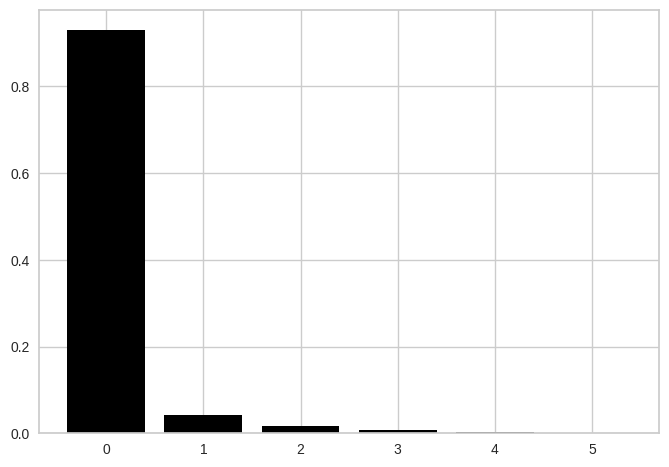

In [142]:
pca = dc.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variables
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

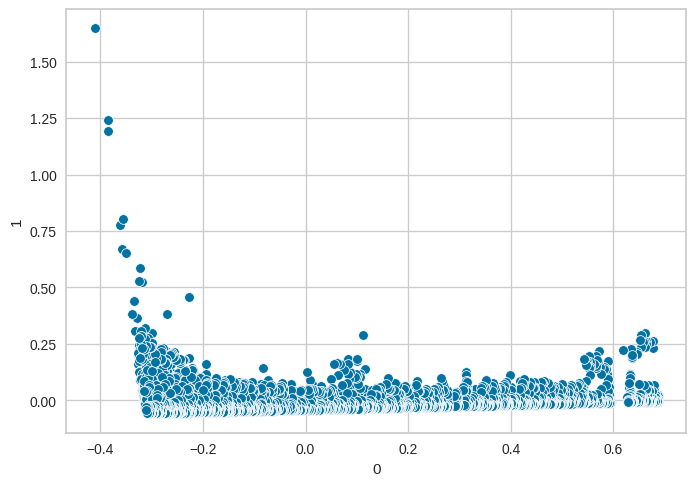

In [143]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.3.2. UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

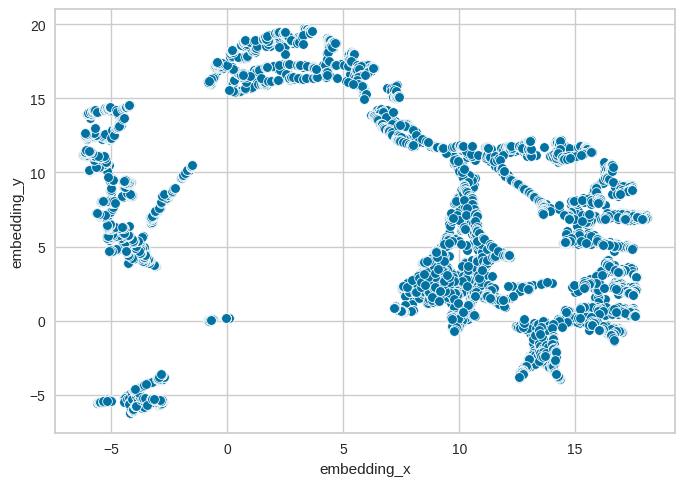

In [144]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 5.3.3. t-SNE

/home/felipe/repos/insiders_clustering/insiders_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/repos/insiders_clustering/insiders_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


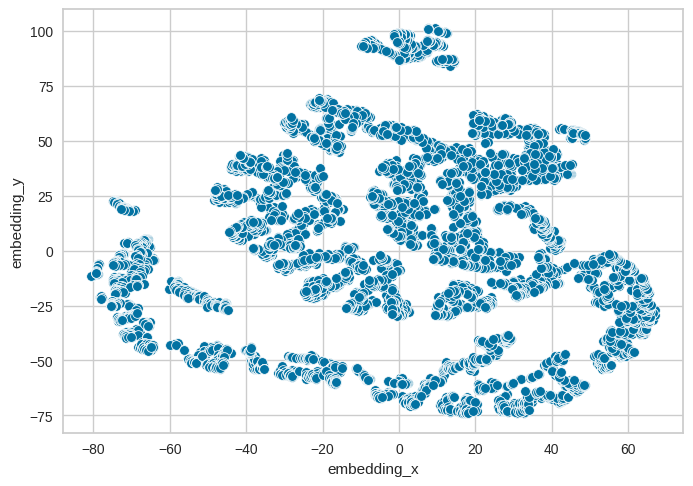

In [145]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.4. Tree-Based Embedding

In [146]:
# training dataset
X = df_ref_53[['recency', 'frequency', 'qty_returns', 'qty_items', 'assortment']]
y = df_ref_53['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)
pickle.dump(rf_model, open('../src/models/rf_model.pkl', 'wb'))

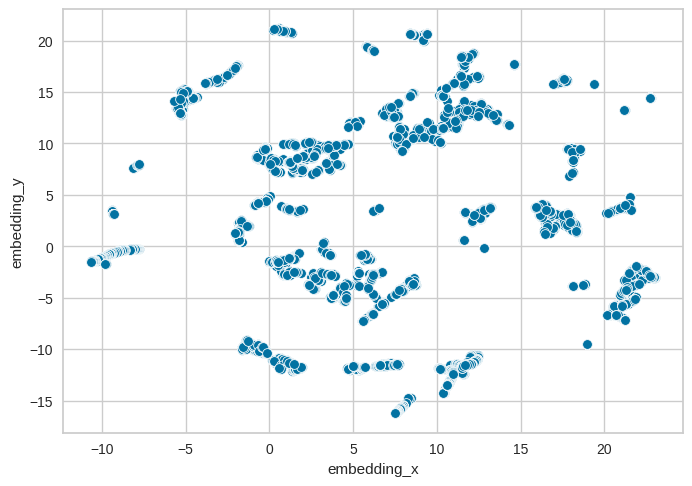

In [147]:
# dataframe leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

# reducer of dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

pickle.dump(reducer, open('../src/features/umap_reducer.pkl', 'wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot df_tree
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6.0. DATA PREPARATION

In [148]:
df_ref_6 = df_tree.copy()

In [149]:
# ss = pp.MinMaxScaler()

# df_ref_6['gross_revenue']   = mm.fit_transform(df_ref_6[['gross_revenue']])
# df_ref_6['avg_ticket']      = mm.fit_transform(df_ref_6[['avg_ticket']])
# df_ref_6['recency']         = mm.fit_transform(df_ref_6[['recency']])
# df_ref_6['frequency']       = mm.fit_transform(df_ref_6[['frequency']])
# df_ref_6['qty_returns']     = mm.fit_transform(df_ref_6[['qty_returns']])
# df_ref_6['amount_returned'] = mm.fit_transform(df_ref_6[['amount_returned']])
# df_ref_6['qty_items']       = mm.fit_transform(df_ref_6[['qty_items']])
# df_ref_6['avg_basket_size'] = mm.fit_transform(df_ref_6[['avg_basket_size']])
# df_ref_6['assortment']      = mm.fit_transform(df_ref_6[['assortment']])

# 7.0. FEATURE SELECTION

In [150]:
# df_ref_7 = df_ref_6[['customer_id', 
#                      'gross_revenue', 
#                      'recency', 
#                      'frequency', 
#                      'qty_returns', 
#                      'qty_items', 
#                      'assortment']].copy()
df_ref_7 = df_ref_6.copy()

# 8.0. HYPER-PARAMETER FINE TUNING

In [151]:
X = df_ref_7.copy()

In [152]:
# number of cluster to test
#clusters = [2, 3, 4, 5, 6, 7, 8]

clusters = np.arange(2, 25, 1)

## 8.1. KMeans

In [153]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = C.KMeans(n_clusters=k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = M.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

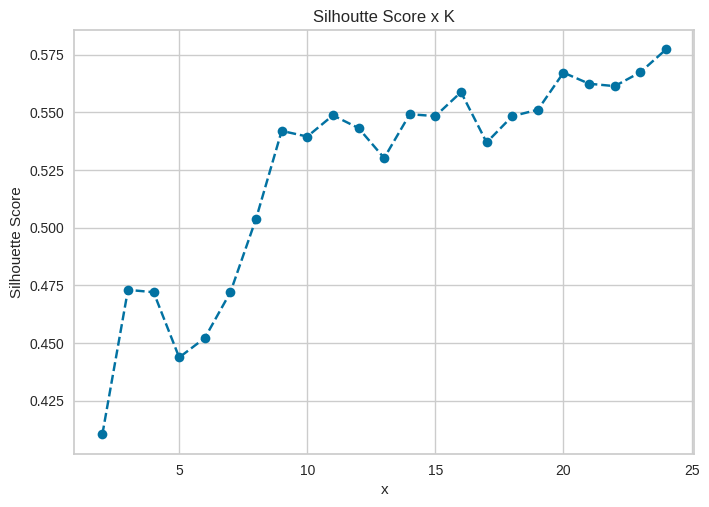

In [154]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.2. GMM

In [155]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=10)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = M.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

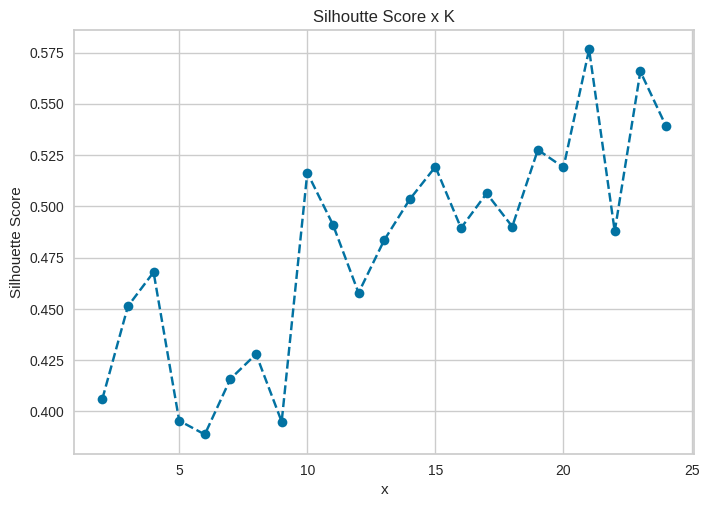

In [156]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.3. Hierarchical Clustering

### 8.3.1. Dendrogram

In [157]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

In [158]:
# hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
# plt.plot()

In [159]:
# hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
# plt.plot()

### 8.3.2. HClustering Silhouette Score

In [160]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model prediction
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = M.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

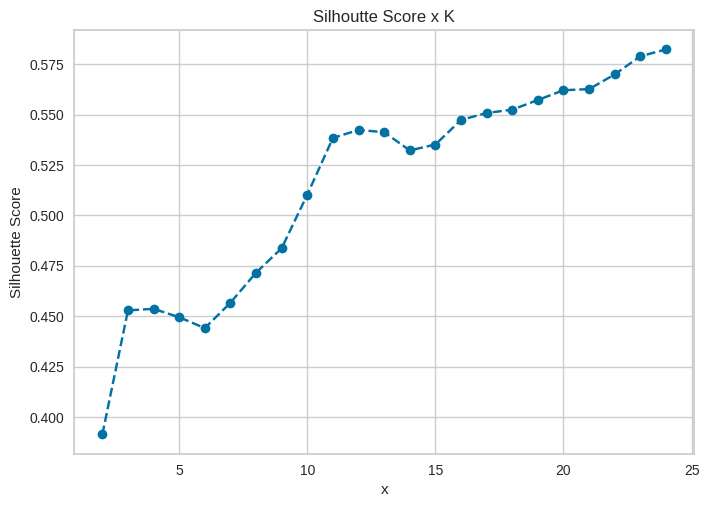

In [161]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.4. DBSCAN

### 8.4.1. Finding Best Parameters

In [162]:
# study = optuna.create_study(direction='maximize') # maximizing the precision at k
# study.optimize(bayesian_opt_objective, n_trials=100); # optimizing the defined function and setting the number of trials
# trial = study.best_trial

# print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
# print(f'Best Hyperparameters = {trial.params}')

### 8.4.2. Apply Model

In [163]:
eps = 0.39
min_samples = 20

# model definition
dbscan_model = C.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = M.silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(set(labels))))
print(set(labels))

Silhouette Score: 0.5569509267807007
Number of Clusters: 78
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, -1}


## 8.5. Silhouette Analysis

### 8.5.1. KMeans

In [164]:
# fig, ax = plt.subplots( 4, 2, figsize=(25, 18) )

# for k in clusters:
#     km = C.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
#     q, mod = divmod( k, 2 )
    
#     visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
#     visualizer.fit( X )
#     visualizer.finalize()

### 8.5.2. GMM

In [165]:
# fig, ax = plt.subplots(4, 2)
# fig.set_size_inches(25, 20)

# for k in clusters:
#     q, mod = divmod(k, 2)
    
#     ax[q-1, mod].set_xlim([-0.1, 1])
#     ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
#     # model definition
#     gmm_model = mx.GaussianMixture(n_components=k, n_init=10)
    
#     # model training
#     gmm_model.fit(X)
    
#     # model predict
#     labels = gmm_model.predict(X)
    
#     # performance
#     SS = M.silhouette_score(X, labels, metric='euclidean')
#     print('For k = {}, Silhoutte Score = {}.'.format(k, SS))
    
#     samples_silhouette_values = M.silhouette_samples(X, labels)
    
#     y_lower = 10
    
#     for i in range(k):
#         # select clusters
#         ith_sample_silhouette_values = samples_silhouette_values[labels==i]
        
#         # sort values
#         ith_sample_silhouette_values.sort()
        
#         # size clusters
#         size_cluster_i = ith_sample_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
        
#         cmap = cm.get_cmap('Spectral')
#         color = cmap(i/k)
        
#         ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sample_silhouette_values, alpha=0.7)
#         ax[q-1, mod].text(-0.05, y_lower+0.05*size_cluster_i, str(i))
        
#         y_lower = y_upper+10
    
#     ax[q-1, mod].set_yticks([])
#     ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#     ax[q-1, mod].set_title('Number of Clusters: %d' %k)
#     ax[q-1, mod].set_xlabel('Silouette Coefficient Value')
#     ax[q-1, mod].set_ylabel('Cluster Label')

### 8.5.3. Hierarchical Clustering

In [166]:
# fig, ax = plt.subplots(4, 2)
# fig.set_size_inches(25, 20)

# for k in clusters:
#     q, mod = divmod(k, 2)
    
#     ax[q-1, mod].set_xlim([-0.1, 1])
#     ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
#     # model definition and training
#     hc_model = hc.linkage(X, 'ward')
    
#     # model predict
#     labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
#     # performance
#     SS = M.silhouette_score(X, labels, metric='euclidean')
#     print('For k = {}, Silhoutte Score = {}.'.format(k, SS))
    
#     samples_silhouette_values = M.silhouette_samples(X, labels)
    
#     y_lower = 10
    
#     for i in range(k):
#         # select clusters
#         ith_sample_silhouette_values = samples_silhouette_values[labels==i]
        
#         # sort values
#         ith_sample_silhouette_values.sort()
        
#         # size clusters
#         size_cluster_i = ith_sample_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
        
#         cmap = cm.get_cmap('Spectral')
#         color = cmap(i/k)
        
#         ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sample_silhouette_values, alpha=0.7)
#         ax[q-1, mod].text(-0.05, y_lower+0.05*size_cluster_i, str(i))
        
#         y_lower = y_upper+10
    
#     ax[q-1, mod].set_yticks([])
#     ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#     ax[q-1, mod].set_title('Number of Clusters: %d' %k)
#     ax[q-1, mod].set_xlabel('Silouette Coefficient Value')
#     ax[q-1, mod].set_ylabel('Cluster Label')

## 8.6. Results

In [167]:
df_results = pd.DataFrame({'KMeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC': hc_list}).T
df_results.columns = clusters

In [168]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.410349,0.473034,0.472026,0.443732,0.452176,0.472029,0.503856,0.541942,0.539488,0.548686,0.543153,0.530184,0.549166,0.548357,0.558730,0.536920,0.548305,0.551117,0.567196,0.562381,0.561342,0.567358,0.577231
GMM,0.406080,0.451331,0.467895,0.395510,0.388785,0.415903,0.427960,0.395022,0.516386,0.491108,0.457832,0.483478,0.503433,0.519285,0.489425,0.506332,0.490125,0.527557,0.518975,0.576479,0.487856,0.565740,0.539154
HC,0.391466,0.452940,0.453734,0.449554,0.444160,0.456748,0.471635,0.483780,0.510309,0.538407,0.542371,0.541241,0.532220,0.535142,0.547308,0.550771,0.552405,0.557200,0.562053,0.562580,0.569888,0.578878,0.582236


# 9.0. MODEL TRAINING

## 9.1. K-Means

In [169]:
# model definition
k = 8
kmeans = C.KMeans(init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 9.1.2. K-Means cluster validation

In [170]:
# WSS (Within-Cluster Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(M.silhouette_score(X, labels, metric='euclidean')))

WSS value: 86964.9921875
SS value: 0.5137798190116882


# 10.0. CLUSTER ANALYSIS

## 10.1. Visualization Inspection

### 10.1.1. Silhoutte Score

/home/felipe/repos/insiders_clustering/insiders_env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


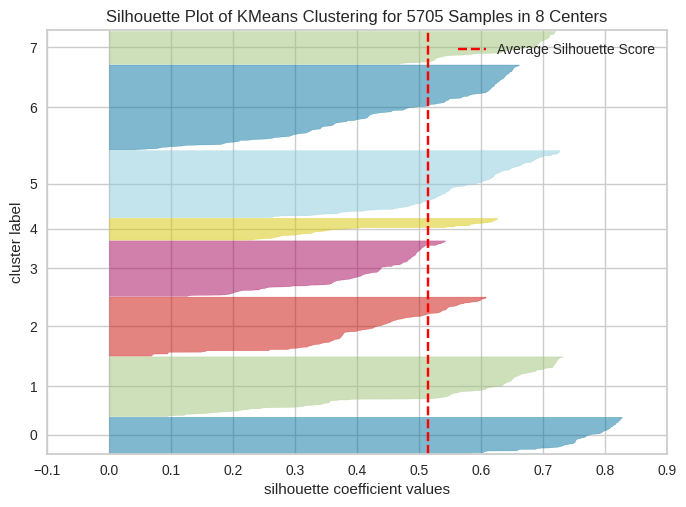

In [171]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 10.1.2 UMAP

In [172]:
# prepare dataframe for vizualization
# df_viz = df_ref_7.copy()
# df_viz['cluster'] = labels
df_viz = X.copy()
df_viz['cluster'] = labels

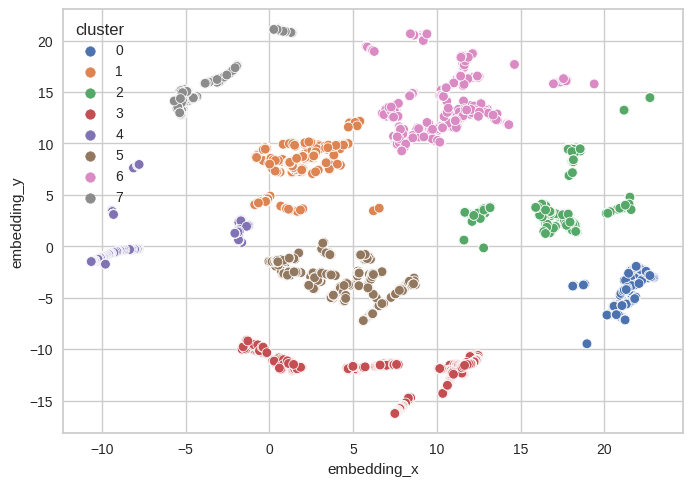

In [173]:
# reducer = umap.UMAP(n_neighbors=25, random_state=42)
# embedding = reducer.fit_transform(X)

# # embedding
# df_viz['embedding_x'] = embedding[:, 0]
# df_viz['embedding_y'] = embedding[:, 1]

# # plot UMAP
# sns.scatterplot(x='embedding_x',
#                 y='embedding_y',
#                 hue='cluster',
#                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
#                 data=df_viz
#                 )

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df_viz, palette='deep');

## 10.2. Clusters Profile

In [174]:
df_ref_10 = df_ref_5[['customer_id',
                      'gross_revenue',
                      'recency',
                      'frequency',
                      'qty_returns',
                      'qty_items',
                      'assortment']].copy()
df_ref_10['cluster'] = labels

In [175]:
# number of customer
df_cluster = df_ref_10[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customer'] = 100*(df_cluster['qty_customers']/df_cluster['qty_customers'].sum())

# avg gross revenue
df_avg_gr = df_ref_10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
df_cluster = pd.merge(df_cluster, df_avg_gr, on='cluster', how='left')

# # avg ticket
# df_avg_tk = df_ref_10[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_tk, on='cluster', how='left')

# avg recency days
df_avg_rd = df_ref_10[['recency', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency':'avg_recency'})
df_cluster = pd.merge(df_cluster, df_avg_rd, on='cluster', how='left')

# avg frequency
df_avg_fr = df_ref_10[['frequency', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequency':'avg_frequency'})
df_cluster = pd.merge(df_cluster, df_avg_fr, on='cluster', how='left')

# avg_qty_returns
df_avg_qr = df_ref_10[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qty_returns':'avg_qty_returns'})
df_cluster = pd.merge(df_cluster, df_avg_qr, on='cluster', how='left')

# # avg_amount_returned
# df_avg_ar = df_ref_10[['amount_returned', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'amount_returned':'avg_amount_returned'})
# df_cluster = pd.merge(df_cluster, df_avg_ar, on='cluster', how='left')

# avg_qty_items
df_avg_qi = df_ref_10[['qty_items', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qty_items':'avg_qty_items'})
df_cluster = pd.merge(df_cluster, df_avg_qi, on='cluster', how='left')

# avg_assortment
df_avg_as = df_ref_10[['assortment', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'assortment':'avg_assortment'})
df_cluster = pd.merge(df_cluster, df_avg_as, on='cluster', how='left')

# # avg_basket_size
# df_avg_bs = df_ref_10[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_bs, on='cluster', how='left')


In [176]:
df_cluster.sort_values(by='avg_gross_revenue', ascending=False).head()

,cluster,qty_customers,perc_customer,avg_gross_revenue,avg_recency,avg_frequency,avg_qty_returns,avg_qty_items,avg_assortment
4,4,298,5.223488,8155.213591,160.134228,6.731544,1.083893,4672.963087,66.422819
7,7,448,7.852761,6298.593482,32.872768,11.799107,2.636161,3779.437500,167.772321
0,0,496,8.694128,2752.289617,57.298387,5.459677,1.062500,1515.344758,156.981855
2,2,808,14.163015,1713.728354,75.608911,3.691832,0.646040,839.566832,109.096535
6,6,1163,20.385627,952.829450,102.998280,2.368874,0.371453,426.435082,69.604471


### 10.2.1. Cluster Insiders

- Cluster: 4
- Number of customers: 298 (5.22% of customer base)
- Average recency (days since last purchase): 160 days
- Average frequency (purchases in last 365 days): 6.7 purchases
- Average gross revenue: $ 8,155.21
- Average quantity of returns: 1
- Average quantity of items purchased: 4673
- Average assortment: 66

# 11.0. CLUSTERS EDA

In [177]:
df_11 = df_ref_10.copy()

## 11.1. Business Questions

### 1. Who are the customers elegible to participate of Insiders group?

In [178]:
 df_11.loc[df_11['cluster'] == 0, 'customer_id'].head()

0     17850
1     13047
22    13448
35    13758
57    15485
Name: customer_id, dtype: int64

### **2.** How many customers will be part of the group?

In [179]:
 df_11.loc[df_11['cluster'] == 0, 'customer_id'].size

496

### **3.** What are main characteristics of these customers?

- Cluster: 4
- Number of customers: 298 (5.22% of customer base)
- Average recency (days since last purchase): 160 days
- Average frequency (purchases in last 365 days): 6.7 purchases
- Average gross revenue: $ 8,155.21
- Average quantity of returns: 1
- Average quantity of items purchased: 4673
- Average assortment: 66

### **4.** What is the revenue participation percentaga from Insiders group?

In [180]:
df_insiders_gr = df_11.loc[df_11['cluster']==7, 'gross_revenue'].sum()
df_all_gr = df_11.loc[:, 'gross_revenue'].sum()

print('Insiders group is responsible for {:.2f}% of gross revenue'.format((df_insiders_gr/df_all_gr)*100))

Insiders group is responsible for 28.79% of gross revenue


### **5.** What is the expected revenue for the next few months from Insiders group?

### **6.** What conditions a customer must meet to be an Insider?

### **7.** What condisions a customer must meet to be excluded from Insiders group?

### **8.** How to ensure that Insiders group is better than the rest of the customer base?

### **9.** What can Marketing do to increase revenue?

# 12.0. DEPLOY